In [1]:
import pandas as pd
file_path = r"C:\Users\Aditi\Documents\Supplychain_Project\archive (2)\supply_chain_data.xlsx"
df = pd.read_excel(file_path)

In [2]:
# Display first 5 rows
print(df.head())

  Product type   SKU      Price  Availability  Number of products sold  \
0     haircare  SKU0  69.808006            55                      802   
1     skincare  SKU1  14.843523            95                      736   
2     haircare  SKU2  11.319683            34                        8   
3     skincare  SKU3  61.163343            68                       83   
4     skincare  SKU4   4.805496            26                      871   

   Revenue generated Customer demographics  Stock levels  Lead times  \
0        8661.996792            Non-binary            58           7   
1        7460.900065                Female            53          30   
2        9577.749626               Unknown             1          10   
3        7766.836426            Non-binary            23          13   
4        2686.505152            Non-binary             5           3   

   Order quantities  ...  Location Lead time  Production volumes  \
0                96  ...    Mumbai        29          

In [3]:
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, LpStatus, value,  PULP_CBC_CMD
# from pulp import PULP_CBC_CMD
# Select required columns
df_selected = df[[
    'SKU', 'Stock levels', 'Order quantities', 'Manufacturing costs',
    'Costs', 'Production volumes'
]].copy()
print(df.columns)

Index(['Product type', 'SKU', 'Price', 'Availability',
       'Number of products sold', 'Revenue generated', 'Customer demographics',
       'Stock levels', 'Lead times', 'Order quantities', 'Shipping times',
       'Shipping carriers', 'Shipping costs', 'Supplier name', 'Location',
       'Lead time', 'Production volumes', 'Manufacturing lead time',
       'Manufacturing costs', 'Inspection results', 'Defect rates',
       'Transportation modes', 'Routes', 'Costs'],
      dtype='object')


In [4]:
#Calculate cost components
df_selected.loc[:, 'Holding Cost'] = 0.10 * df_selected['Manufacturing costs']
df_selected.loc[:, 'Ordering Cost'] = df_selected['Manufacturing costs'] + df_selected['Costs']
# Create LP Minimization problem
model = LpProblem(name = "Inventory_Optimization", sense = LpMinimize)


In [5]:
#Define Decision Variables
#Let x[i] be the number of units to stock for SKU i
#Create LP variables for each SKU
x = {row['SKU']: LpVariable(name = f"x_{row['SKU']}", lowBound =0, cat = 'Continuous') 
    for _, row in df_selected.iterrows()}

In [6]:
#Minimize Total Cost = Holding + Ordering
model +=lpSum(
    df_selected.loc[i, 'Holding Cost'] * x[sku] +
    df_selected.loc[i, 'Ordering Cost'] * (x[sku] - df_selected.loc[i, 'Stock levels'])
    for i, sku in enumerate(df_selected['SKU'])

), "Total_Cost"

In [7]:
#Adding constraints
#Constraint 1: Meet Demand
for i, row in df_selected.iterrows():
    model += x[row['SKU']] >= row['Order quantities'], f"demand_constraint_{row['SKU']}"
#Constraint 2: Not Exceed Production Capacity
for i, row in df_selected.iterrows():
    model += x[row['SKU']] <= row['Production volumes'], f"production_constraint_{row['SKU']}"


In [8]:
#Solve the model
# status = model.solve()            
model.solve(PULP_CBC_CMD(msg=False))
print(f"Solver Status: {LpStatus[model.status]}")
print("Total Cost Incurred:", round(value(model.objective), 2))

Solver Status: Optimal
Total Cost Incurred: 225891.18


In [9]:
#Print optimal stock levels and cost
results = []

for sku in df_selected['SKU']:
    optimal_stock = x[sku].value()
    results.append({
        'SKU': sku,
        'Optimal Stock Level': round(optimal_stock, 2),
        'Current Stock': df_selected[df_selected['SKU'] == sku]['Stock levels'].values[0],
        'Order Quantity': df_selected[df_selected['SKU'] == sku]['Order quantities'].values[0],
        'Cost Incurred': round(value(model.objective), 2)
       
    })

results_df = pd.DataFrame(results)
print(results_df.head(20))


      SKU  Optimal Stock Level  Current Stock  Order Quantity  Cost Incurred
0    SKU0                 96.0             58              96      225891.18
1    SKU1                 37.0             53              37      225891.18
2    SKU2                 88.0              1              88      225891.18
3    SKU3                 59.0             23              59      225891.18
4    SKU4                 56.0              5              56      225891.18
5    SKU5                 66.0             90              66      225891.18
6    SKU6                 58.0             11              58      225891.18
7    SKU7                 11.0             93              11      225891.18
8    SKU8                 15.0              5              15      225891.18
9    SKU9                 83.0             14              83      225891.18
10  SKU10                 80.0             51              80      225891.18
11  SKU11                 60.0             46              60      225891.18

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
averages = {
    'Current Stock': results_df['Current Stock'].mean(),
    'Optimal Stock Level': results_df['Optimal Stock Level'].mean(),
    'Order Quantity': results_df['Order Quantity'].mean()
}

# Convert to DataFrame for easy plotting
avg_df = pd.DataFrame(list(averages.items()), columns=['Metric', 'Average Value'])
print(avg_df)


                Metric  Average Value
0        Current Stock          47.77
1  Optimal Stock Level          49.22
2       Order Quantity          49.22


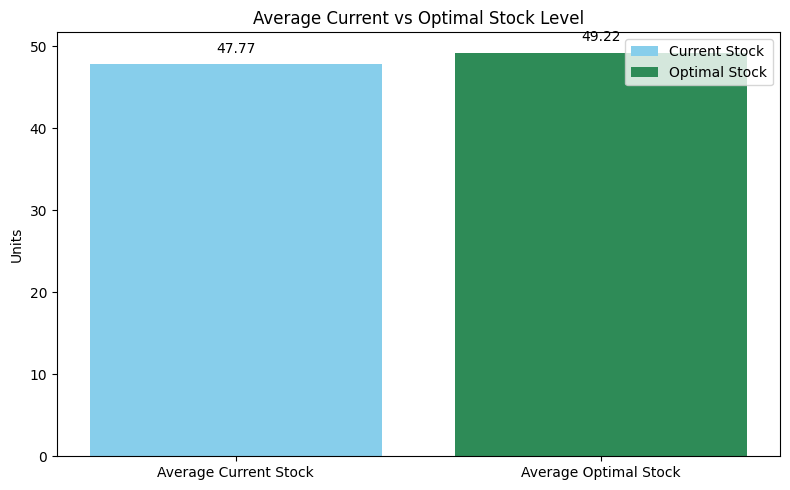

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

avg_current = results_df['Current Stock'].mean()
avg_optimal = results_df['Optimal Stock Level'].mean()

stock_types = ['Average Current Stock', 'Average Optimal Stock']
stock_values = [avg_current, avg_optimal]
colors = ['skyblue', 'seagreen']

plt.figure(figsize=(8, 5))
bars = plt.bar(stock_types, stock_values, color=colors)

plt.legend(bars, ['Current Stock', 'Optimal Stock'], loc='upper right')

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,   
        height + 1,                          
        f'{height:.2f}',                     
        ha='center', va='bottom', fontsize=10
    )

plt.title('Average Current vs Optimal Stock Level')
plt.ylabel('Units')
plt.xlabel('')
plt.tight_layout()
plt.show()
